# Hospital Readmission Prediction
## Model Training and Deployment
We cleaned and filtered the raw data and saved a dataset with one row per patient in the previous notebook `1-data-preprocessing`. In this notebook, we will go through end to end process of importing the prepared data, analysing the features and correlation between them, building and testing machine learning models, selecting the best performing model, explaining feature importance and deploying the model. 


In the cell below we import the python libraries that we will use throughout the notebook. 
`matplotlib` and `seaborn` libraries are used to visualize the data. `sklearn` library is used to build transformers and machine learning models. `lime` library is used to provide explanation to individual patients readmission risk.
We install `lime` library if it doesn't already exist. 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os

import seaborn as sns
sns.set(style='darkgrid',palette="deep")
from zipfile import ZipFile
import joblib
import string
import random

from project_lib import Project
project = Project()

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn import metrics
import tqdm


try:
    import lime
except:
    !pip install lime
    import lime
import lime.lime_tabular
    

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=aa622d667fa939bf4e73a8a1e79401d1814412c7ed9008fb13241252ba621af5
  Stored in directory: /tmp/1000670000/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


## Load training data
We load the training data prepared in the notebook `1-data-preprocessing`. Training data set contains 1 row per patient with patients health records, admission and discharge records, lab, diagnoses and procedures details and the target variable to indicate whether the patient was readmitted within 30 days of discharge or not."

In [2]:
hospital_details = project.get_file("training-data.csv")
hospital_details.seek(0)
df_hospital = pd.read_csv(hospital_details)
df_hospital.head()

,ENCOUNTER_ID,PATIENT_NBR,RACE,GENDER,AGE,WEIGHT,ADMISSION_TYPE_ID,DISCHARGE_DISPOSITION_ID,ADMISSION_SOURCE_ID,TIME_IN_HOSPITAL,PAYER_CODE,MEDICAL_SPECIALTY,NUM_LAB_PROCEDURES,NUM_PROCEDURES,NUM_MEDICATIONS,NUMBER_OUTPATIENT,NUMBER_EMERGENCY,NUMBER_INPATIENT,DIAG_1,DIAG_2,DIAG_3,NUMBER_DIAGNOSES,MAX_GLU_SERUM,A1CRESULT,METFORMIN,REPAGLINIDE,NATEGLINIDE,CHLORPROPAMIDE,GLIMEPIRIDE,ACETOHEXAMIDE,GLIPIZIDE,GLYBURIDE,TOLBUTAMIDE,PIOGLITAZONE,ROSIGLITAZONE,ACARBOSE,MIGLITOL,TROGLITAZONE,TOLAZAMIDE,EXAMIDE,CITOGLIPTON,INSULIN,GLYBURIDE-METFORMIN,GLIPIZIDE-METFORMIN,GLIMEPIRIDE-PIOGLITAZONE,METFORMIN-ROSIGLITAZONE,METFORMIN-PIOGLITAZONE,CHANGE,DIABETESMED,READMITTED,FIRST_NAME,LAST_NAME
0,2278392,8222157,Caucasian,Female,[0-10),Unknown,Not Available,Unknown,Physician Referral,1,OTHER,Pediatrics-Endocrinology,41,0,1,0,0,0,"Endocrine, Nutritional And Metabolic",Infectious And Parasitic,Infectious And Parasitic,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,Ima,Labadie
1,149190,55629189,Caucasian,Female,[10-20),Unknown,Emergency,Discharged to home,Emergency Room,3,OTHER,NaN,59,0,18,0,0,0,"Endocrine, Nutritional And Metabolic","Endocrine, Nutritional And Metabolic","Endocrine, Nutritional And Metabolic",9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,Brycen,Hermiston
2,500364,82442376,Caucasian,Male,[30-40),Unknown,Emergency,Discharged to home,Emergency Room,2,OTHER,NaN,44,1,16,0,0,0,Infectious And Parasitic,"Endocrine, Nutritional And Metabolic",Circulatory System,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,Leonor,Cummerata
3,16680,42519267,Caucasian,Male,[40-50),Unknown,Emergency,Discharged to home,Emergency Room,1,OTHER,NaN,51,0,8,0,0,0,Neoplasms,Neoplasms,"Endocrine, Nutritional And Metabolic",5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,Nicolas,Baumbach
4,35754,82637451,Caucasian,Male,[50-60),Unknown,Urgent,Discharged to home,Clinic Referral,3,OTHER,NaN,31,6,16,0,0,0,Circulatory System,Circulatory System,"Endocrine, Nutritional And Metabolic",9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,0,Deshawn,Ryan


## Functions

The following cell contains a function which generates a number of plots which are used for some preliminary analysis. The first chart shows the scatter plots of the each numerical variable and the target variable. If the variable is categorical, a second plot is generated which shows the the distribution of the target variable within each category of the categorical variable. These plots give the data scientist an idea of what single variables can influence the readmissions in diabetic patients.

In [3]:
def plot_distribution_and_target_density(df, col_name, chart_type, target_col):
    if chart_type == 'numerical':
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
        plt.subplots_adjust(hspace = 0.4)
        ax1.set_title('Variable Distribution - ' + col_name)
        dist_plt = sns.histplot(df[col_name], kde=False, ax=ax1)   
        # bin the numerical data
        # if there are less than 10 unique numbers, just split into the number of unique numbers
        if len(df[col_name].unique()) < 10:
            df[col_name + '_BINNED'] = pd.qcut(df[col_name], len(df[col_name].unique())-1,duplicates='drop')
        else:
            df[col_name + '_BINNED'] = pd.qcut(df[col_name], 10,duplicates='drop')
        col_name = col_name + '_BINNED'
        

    elif chart_type == 'categorical':
        fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(25, 5))
        plt.subplots_adjust(hspace = 0.4)

    df_var_summary = df.groupby(col_name)[target_col].agg(['count', 'mean']).reset_index()
    df_var_summary.rename(columns={'count':'Number of Records', 'mean':'Target Density'}, inplace=True)
    
    # if we are using a binned variable sort binning lowest to highest
    # we can also drop it from the raw data nowa
    # if categorical, sort by the number of records
    if chart_type == 'numerical': 
        df_var_summary.sort_values(col_name, inplace=True)
        df.drop(col_name, axis=1, inplace=True)
    elif chart_type == 'categorical':
        df_var_summary.sort_values('Number of Records', inplace=True, ascending=False)

    ax2.set_title('Number of Records per Category - ' + col_name)

    category_plt = sns.barplot(x=col_name,y='Number of Records',data=df_var_summary, color="skyblue", ax=ax2)
    category_plt = category_plt.set_xticklabels(category_plt.get_xticklabels(), rotation=30, horizontalalignment='right')
    category_plt = ax2.set_xlabel('')

    target_density_plot = sns.barplot(x=col_name, y='Target Density', data=df_var_summary, color="skyblue", ax=ax3)

    ax3.set_title('Target Density per Category - ' + col_name)

    for patch in ax3.patches:
        bar_height = patch.get_height()
        ax3.text(patch.get_x()+patch.get_width()/2.,
                bar_height/2,
                np.round(bar_height, 2),
                ha='center', color='white', weight='bold', fontsize=10) 

    target_density_plot.axhline(y=df[target_col].mean(), ls='--')
    target_density_plot.text(1, df[target_col].mean() + 0.01, 'Average Target Density :' + str(np.round(df[target_col].mean(), 2)), fontsize=10, va='center', ha='center')
    target_density_plot = target_density_plot.set_xticklabels(target_density_plot.get_xticklabels(), rotation=30, horizontalalignment='right')
    target_density_plot = ax3.set_xlabel('')
    
    return

This function plots an annotated and more presentable variable importance plot for the top 10 variables.

In [4]:
def plot_feature_importance(feature_list, feature_importances, title='Feature Importance Plot'):
    """
    Function to Plot Feature Importances
    """
    features = feature_list
    importances = feature_importances
    indices = np.argsort(importances)[-10:]
    
    plt.figure(figsize=(12,7))
    plt.title(title, fontsize=16, fontweight='bold')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
  
    return

### Specify User Inputs

We specify the user inputs in the cell below.

**target_col :** Target variable indicating whether a patient was readmitted or not.<br>
**categorical_cols :** A list of all categorical variables that need to be transformed before input into the model. We will use a transformer to impute missing values and create dummy variables.<br>
**numerical_cols :** A list of all of the numerical features that we input into the model. Later in the code, we use a transformer to impute any missing values in these columns. Flag like variables, with values of either 1 or 0 are included in this list.<br>
**cat_pct :** A threshold that defines the percentage of unique values in a categorical feature that is acceptable for one-hot encoding.<br>
**cor_pct :** A threshold that defines the level of correlation at which point a feature needs to be removed from analysis.<br>


If the data scientist is using their own data, they can easily update the variables below to point at their own specific column names.

All of these variables are stored in a dictionary which is saved as part of the metadata when deploying the pipeline in the deployment space. We store this dictionary so that the same user inputs can be applied when scoring new data.

In [5]:
numerical_cols=['TIME_IN_HOSPITAL','NUM_LAB_PROCEDURES','NUM_PROCEDURES','NUM_MEDICATIONS','NUMBER_OUTPATIENT','NUMBER_EMERGENCY','NUMBER_DIAGNOSES']


target_col='READMITTED'
categorical_cols=['RACE','GENDER','AGE','WEIGHT','ADMISSION_TYPE_ID','DISCHARGE_DISPOSITION_ID','ADMISSION_SOURCE_ID','PAYER_CODE',
                  'DIAG_1','DIAG_2','DIAG_3','MAX_GLU_SERUM','A1CRESULT','METFORMIN','REPAGLINIDE','NATEGLINIDE','CHLORPROPAMIDE','GLIMEPIRIDE','ACETOHEXAMIDE','GLIPIZIDE','GLYBURIDE','TOLBUTAMIDE',
                  'PIOGLITAZONE','ROSIGLITAZONE','ACARBOSE','MIGLITOL','TROGLITAZONE','TOLAZAMIDE','EXAMIDE','CITOGLIPTON','INSULIN','GLYBURIDE-METFORMIN','GLIPIZIDE-METFORMIN','GLIMEPIRIDE-PIOGLITAZONE',
                  'METFORMIN-ROSIGLITAZONE','METFORMIN-PIOGLITAZONE','CHANGE','DIABETESMED']


cat_pct = 0.05
cor_pct = 0.90

In [6]:
df_prep=df_hospital[numerical_cols+[target_col]+categorical_cols].copy()

### Handle categorical variables
Categorical variables with a high number of unique values can significantly impact performance, because they may add too many one-hot encoded features to the dataset. We remove such categorical variables. 

In [7]:
for col in categorical_cols:
    if df_prep[col].nunique() > (cat_pct*df_prep.shape[0]):
        categorical_cols.remove(col)
        df_prep=df_prep.drop(col,axis=1)

In [8]:
for col in categorical_cols:
    if df_prep[col].nunique() ==1:
        categorical_cols.remove(col)
        df_prep=df_prep.drop(col,axis=1)

Also remove the columns which have only one single category for all the rows.

In [9]:
categorical_cols_updated=[]
for cols in categorical_cols:
    if df_prep[cols].nunique() != 1:
        categorical_cols_updated.append(cols)
df_prep=df_hospital[numerical_cols+[target_col]+categorical_cols_updated].copy()
categorical_cols=categorical_cols_updated

## Visualise Input Data

#### Plot Categorical Columns
The below cell plots some of the categorical columns to understand their distribution.

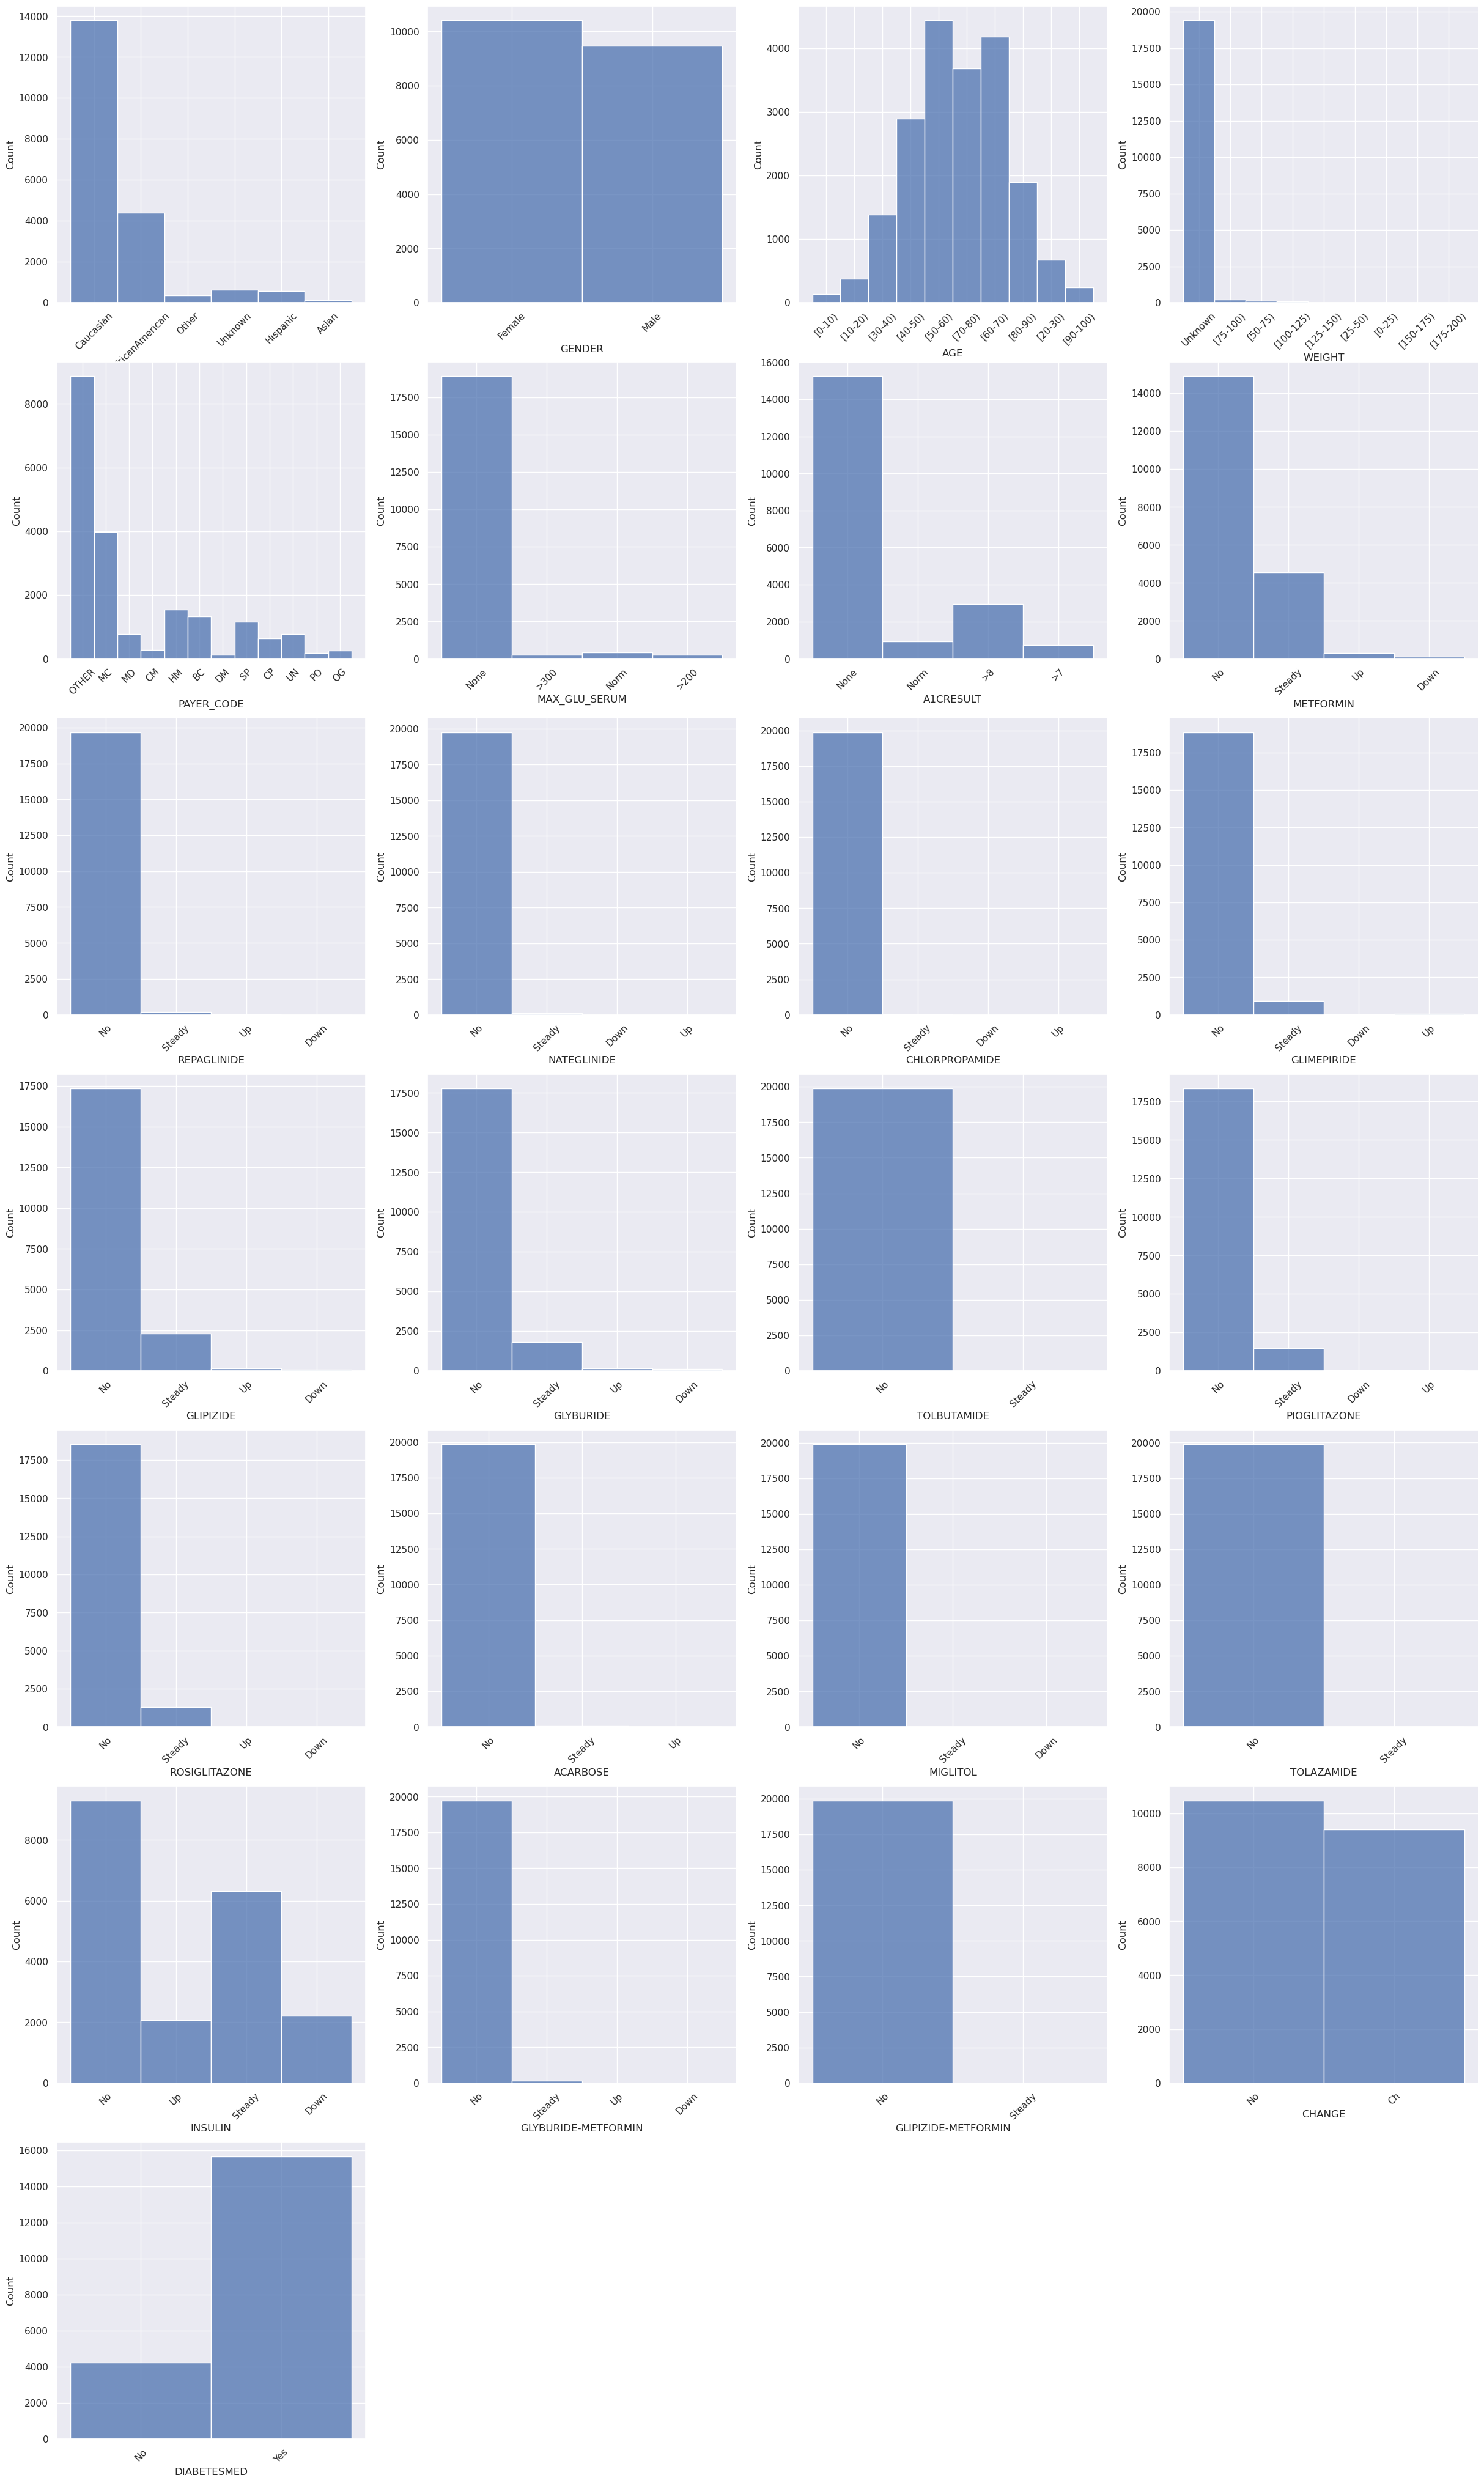

In [10]:
f = plt.figure(figsize=(30,150))
c=0
for i in categorical_cols:
    if ("DIAG" not in i) & ("_ID" not in i):
    
        f.add_subplot(20, 4, c+1)
        plt.xticks(rotation=45)
        sns.histplot(df_prep[i])
        c=c+1
plt.show()


The below cell plots all the numerical variables in the data to understand the distribution and skewnes in the data.  

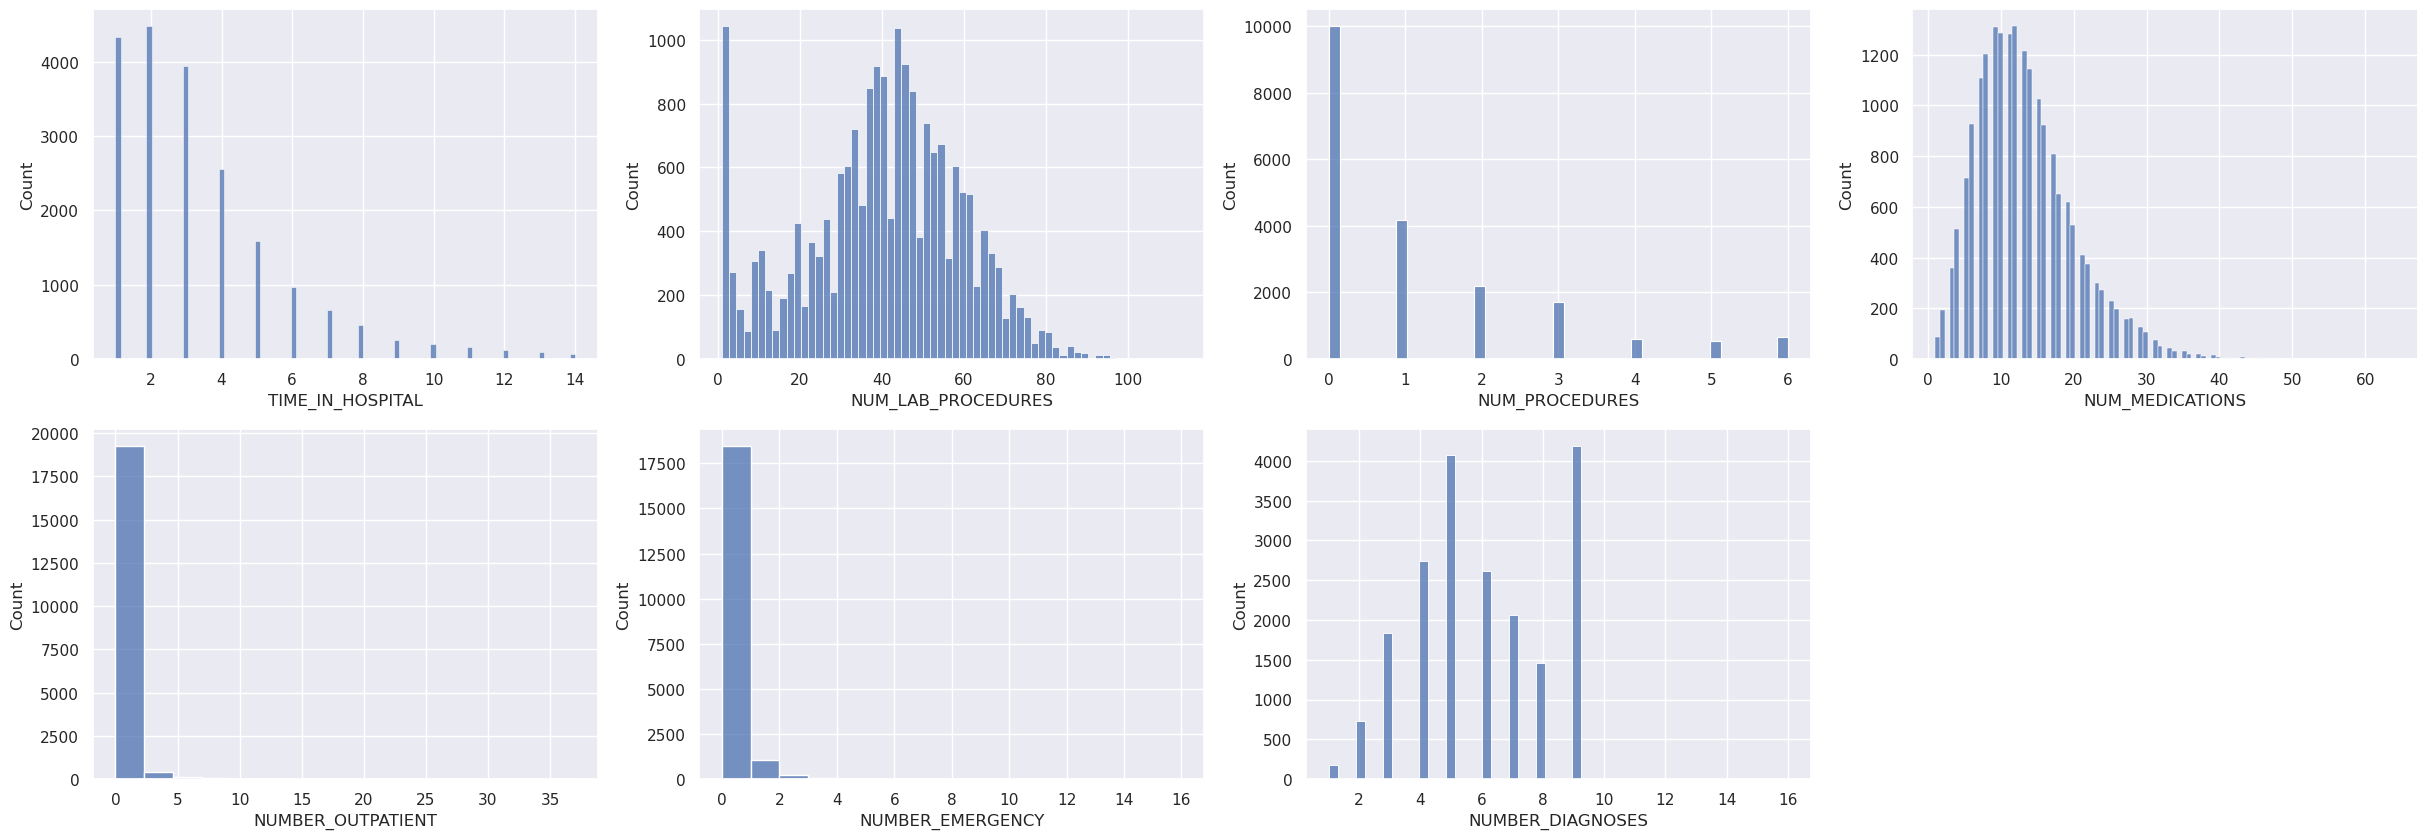

In [11]:
f = plt.figure(figsize=(30,10))
c=0
for i in numerical_cols:
    
    f.add_subplot(2, 4, c+1)
    sns.histplot(df_prep[i])
    c=c+1
plt.show()

We can observe `number_outpatient` and `number_emergency` features are highly skewed. Since we are using decision tree methods to predict readmission we don't need to use log transform or any other method to handle the skewness.

As already described, we use the `plot_distribution_and_target_density` function to create plots for a selection of variables. The user specifies the column to be visualised and whether the column is numerical or categorical.

#### 3. discharge_disposition_id

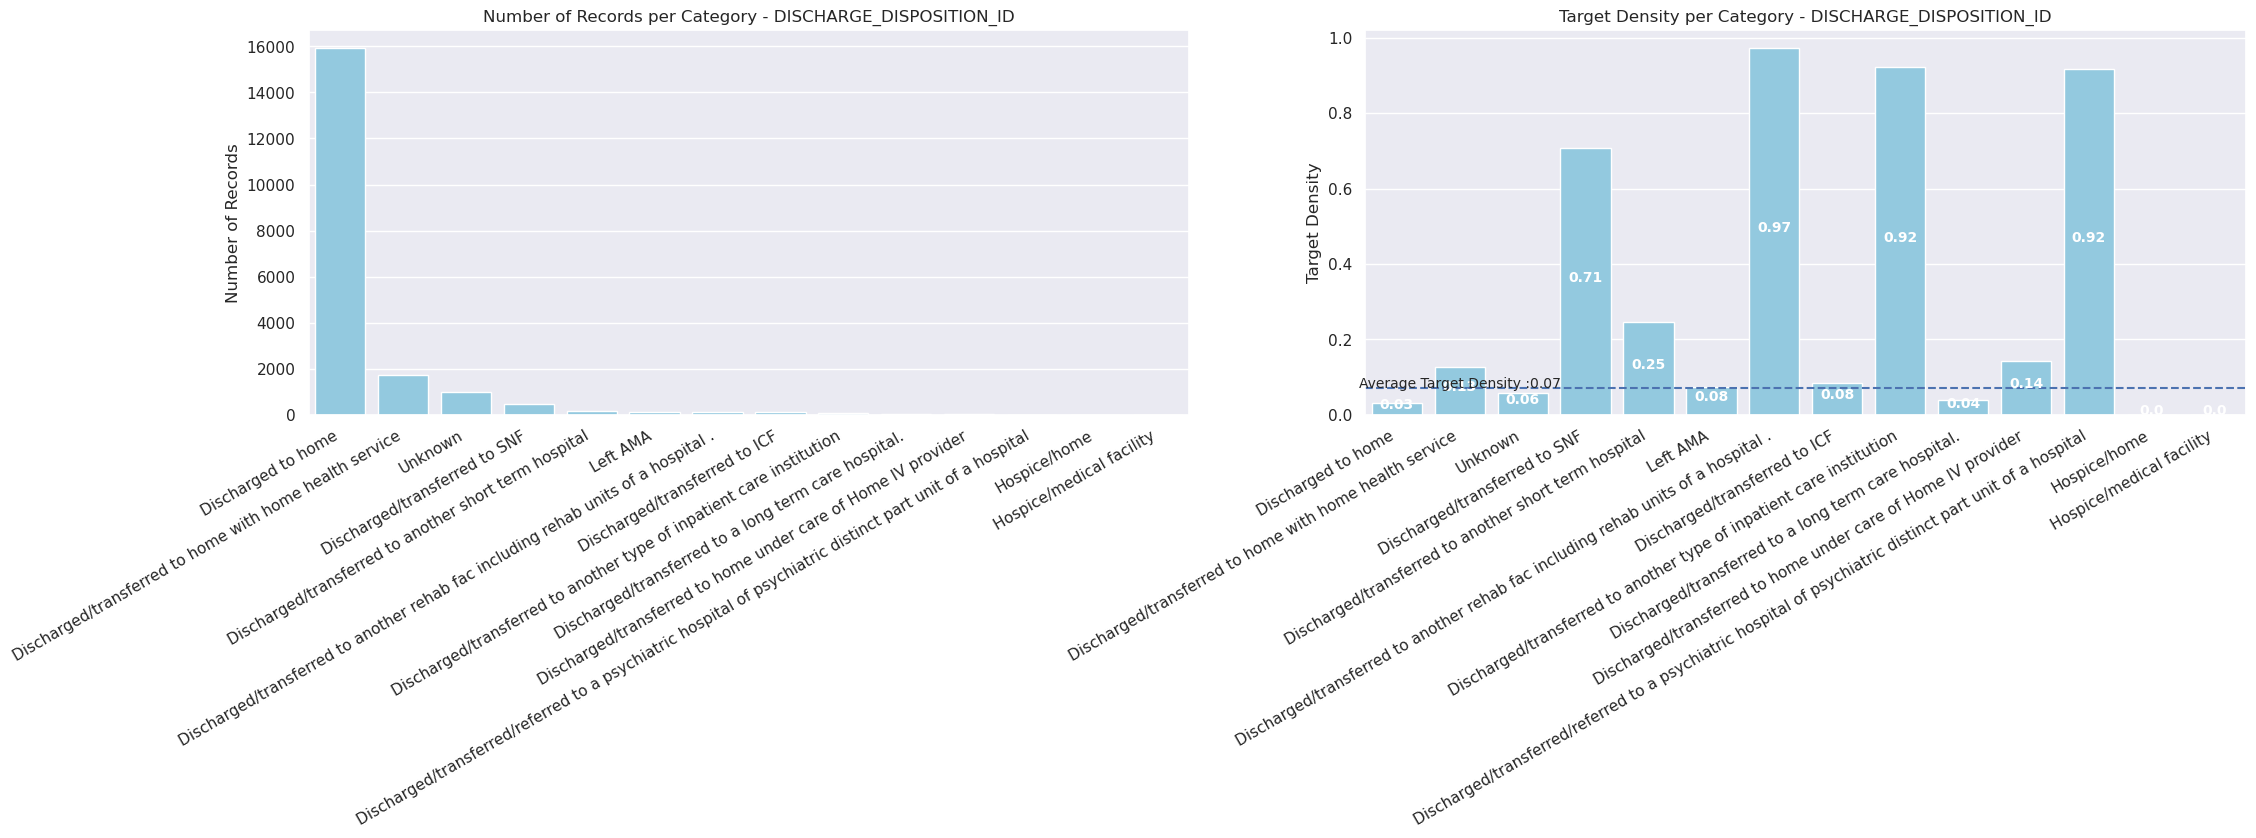

In [12]:
plot_distribution_and_target_density(df_prep, 'DISCHARGE_DISPOSITION_ID', 'categorical', target_col)

#### 2. payer_code

We then plot PAYER CODE. This variable has 12 categories. We see some variation in the target density plot. Patients with payer codes `OTHER`, `MC`, `CM` are more likely to be readmitted than others.

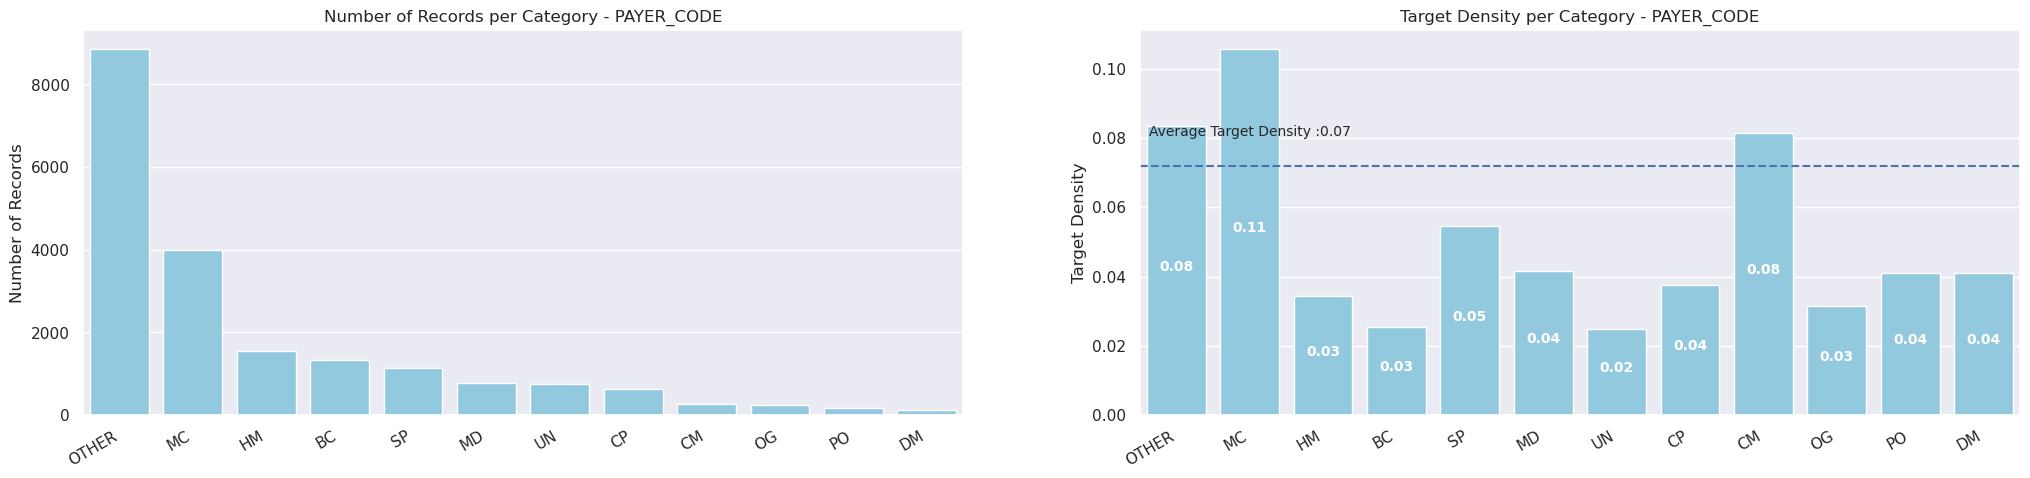

In [13]:
plot_distribution_and_target_density(df_hospital, 'PAYER_CODE', 'categorical', target_col)

#### 3. number_diagnoses
Taking an example of a numerical variable, we plot `number_diagnoses`. The values for number of diagnoses range from 0 to 16, with a slight skew. Looking at the target density after bucketing the variable, we see quite a bit of variation. The patients with a higher number of diagnoses are more likely to be readmitted.

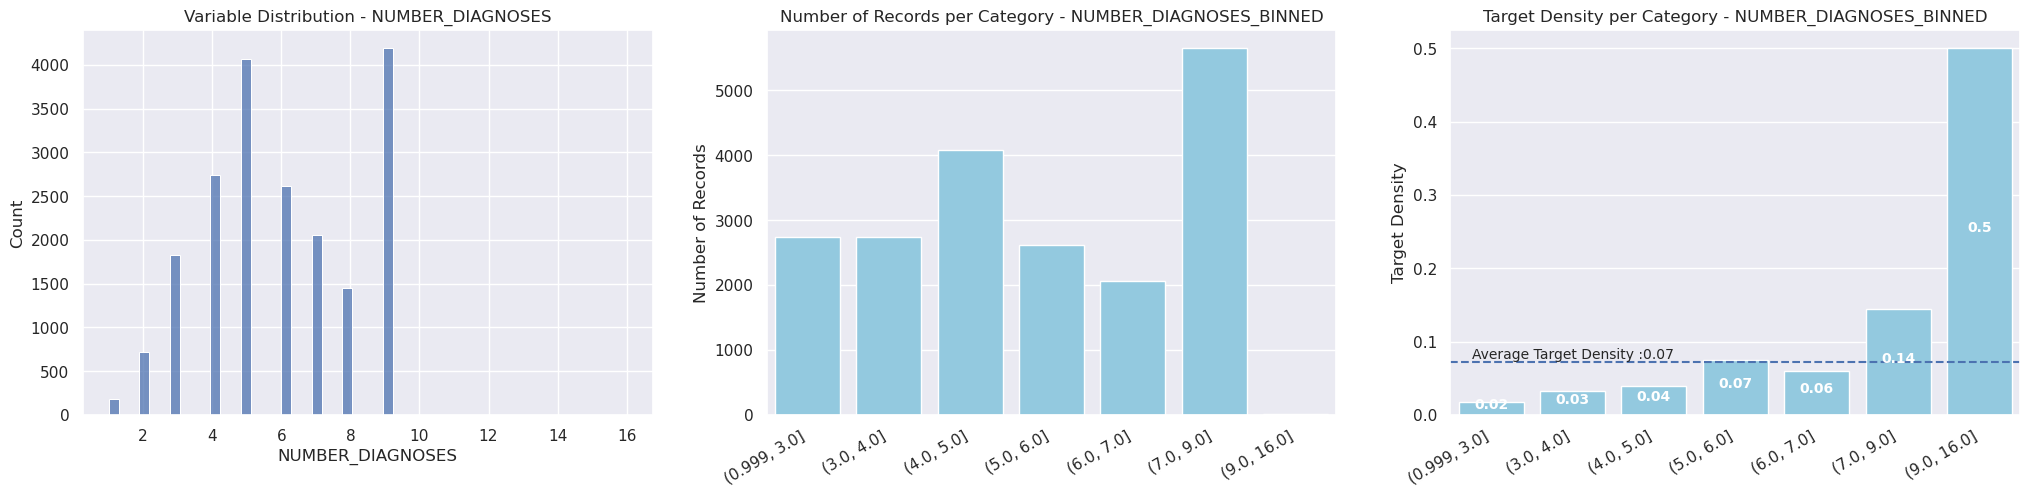

In [14]:
plot_distribution_and_target_density(df_prep, 'NUMBER_DIAGNOSES', 'numerical', target_col)


#### 4. Target Column 
We plot the distribution of the target variable below, first at a total level, looking at the percentage of patients who readmit and don't readmit. Only 7.2% of patients readmit over the analysis period.

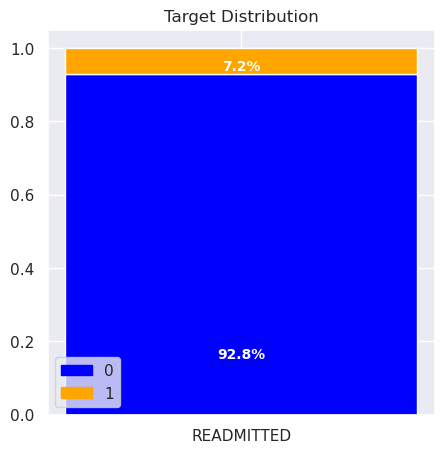

In [15]:

df_temp = df_prep[target_col].value_counts().reset_index()
df_temp['perc'] = df_temp[target_col] / df_temp[target_col].sum()

target_0 = df_temp[df_temp['index']==0]['perc'].values[0]
target_1 = df_temp[df_temp['index']==1]['perc'].values[0]

fig1, ax1 = plt.subplots(figsize=(5,5))

ax1.bar(target_col, target_0, label=target_0, color='blue')
ax1.bar(target_col, target_1, bottom=target_0, color='orange')

red_patch = mpatches.Patch(color='orange', label='1')
blue_patch = mpatches.Patch(color='blue', label='0')

plt.legend(handles=[blue_patch, red_patch], loc='best')

plt.title('Target Distribution')

for patch in ax1.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height())
    x = patch.get_x() + patch.get_width()/2
    y = patch.get_y() + patch.get_height()/6
    ax1.annotate(percentage, (x, y), ha='center', color='white', weight='bold', fontsize=10)

#### 5. Correlation
We carry out a correlation analysis on all variables specified in numerical_cols.

From the result of the analysis we can see that there is no significant correlation between the columns. 

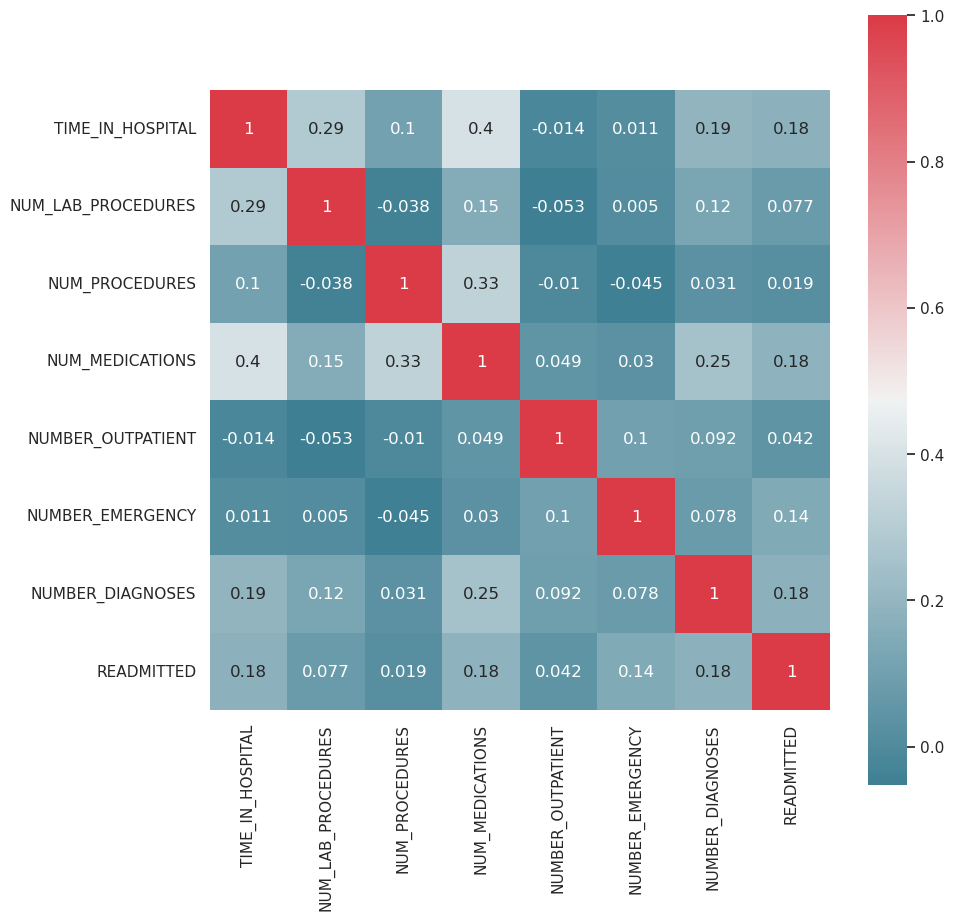

In [16]:

# check correlation between numerical features
f, ax = plt.subplots(figsize=(10, 10))
corr = df_prep[numerical_cols + [target_col]].corr()
corr = corr.round(3)
temp = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
           square=True, ax=ax,annot=True)

### Handle correlations
Correlated data poses the threat of disproportionately reporting the effects of features with relatively similarly. 

In [17]:
corr = corr.abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] >= cor_pct)]

df_prep = df_prep.drop(to_drop, axis=1)


### Split Data and Build Transformer


We split the data into training, validation and test sets. We use 60% of the data for training, 20% for validation and the remaining 20% for testing. We first remove records with missing values for the target variable. 

We build the models on the training set, carry out hyperparameter tuning on the validation set and finally apply the selected final model to the unseen test set.  

We use built-in sklearn transformers to process the data and get it ready for input into the model. 

For categorical variables we create a pipeline with 2 steps. We first use the `SimpleImputer` transformer to fill in missing values with 'Other'. Next we use `OneHotEncoder` to create dummy variables for each category. The transformers are applied to the features specified in the `categorical_cols` variable.

For numerical variables the pipeline has a single step in our example. We again use the `SimpleImputer` transformer to fill in missing values. The transformer is applied to the features specified in `numerical_cols`variable.  

The transformers are combined, we fit using the training data and transform the training, validation and test data. The transformer is saved out as a joblib object. It can be imported and used again when preparing new data for scoring. The feature names of the combined transformers are retrieved and stored in a list `numerical_cols`. This list is used for labelling the feature importance of the final model.

In [18]:

X = df_prep.dropna(axis=0, subset=[target_col]).drop([target_col], axis=1)
y = df_prep.dropna(axis=0, subset=[target_col])[target_col]

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, stratify=y, test_size=0.40, random_state=123)
X_validation, X_test, y_validation, y_test = train_test_split(X_val_test, y_val_test, stratify=y_val_test, test_size=0.50, random_state=123)

In [19]:

categorical_transformer = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='constant', fill_value='Other')), ('dummy_vars', OneHotEncoder(handle_unknown='ignore'))])
# fill in missing data - we use median to keep the 1, 0  'flag' like variables either 1 or 0
numeric_transformer = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='median'))])

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
            ])

In [21]:
fitted_preprocessor = preprocessor.fit(X_train)

X_train_postprocess = fitted_preprocessor.transform(X_train)
X_validation_postprocess = preprocessor.transform(X_validation)
X_test_postprocess = preprocessor.transform(X_test)

In [22]:
onehot_columns=list(fitted_preprocessor.named_transformers_['cat'].named_steps['dummy_vars'].get_feature_names_out(input_features=categorical_cols))
numeric_features_list = list(numerical_cols)
numeric_features_list.extend(onehot_columns)

In [23]:
# Save out the transformer
# mimetype is guessed when promoting the asset into the deployment space
# we need to save the file as a type recognised by the mimetype library
# this doesn't impact the object type
joblib.dump(fitted_preprocessor, 'preprocessor_transformer.txt')

['preprocessor_transformer.txt']

## Build Machine Learning Models

### Model Hyperparameter Tuning and Model Selection

We selected a random forest model for this example and do some hyperparameter tuning. We train the models on the newly balanced data before applying them to the imbalanced validation data. The hyperparameter selection which performs best on the imbalanced validation data is selected as final. We use AUC as the evaluation metric.

In [24]:
l_ne = [10, 50]
l_md = [5,7, 10] 
l_mf = [0.75, 0.9]

highest_validation_auc = 0.0
top_ne = 0
top_md = 0
top_mf = 0.0

for ne in l_ne:
    for md in l_md:
        for mf in l_mf:
            clf = RandomForestClassifier(n_estimators=ne, max_depth=md, max_features=mf, random_state=0)
            clf.fit(X_train_postprocess, y_train)
            
            y_pred_train = clf.predict_proba(X_train_postprocess)[:,1]
            y_pred_validation = clf.predict_proba(X_validation_postprocess)[:,1]
            
            fpr_validation, tpr_validation, thresholds_validation = metrics.roc_curve(y_validation, y_pred_validation)
            fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)

            auc_validation = metrics.auc(fpr_validation, tpr_validation)
            auc_train = metrics.auc(fpr_train, tpr_train)
            
            if auc_validation > highest_validation_auc:
                print('Training AUC : ' + str(np.round(auc_train, 3)) + ', Validation AUC :' + str(np.round(auc_validation, 3)) + ' from ' + str(ne) + ' estimators, ' + str(md) + ' max depth and ' + str(mf) + ' max features***')
                top_ne = ne
                top_md = md
                top_mf = mf
                highest_validation_auc = auc_validation
            else:
                print('Training AUC : ' + str(np.round(auc_train, 3)) + ', Validation AUC :' + str(np.round(auc_validation, 3)) + ' from ' + str(ne) + ' estimators, ' + str(md) + ' max depth and ' + str(mf) + ' max features')

Training AUC : 0.855, Validation AUC :0.852 from 10 estimators, 5 max depth and 0.75 max features***
Training AUC : 0.855, Validation AUC :0.853 from 10 estimators, 5 max depth and 0.9 max features***
Training AUC : 0.88, Validation AUC :0.864 from 10 estimators, 7 max depth and 0.75 max features***
Training AUC : 0.884, Validation AUC :0.87 from 10 estimators, 7 max depth and 0.9 max features***
Training AUC : 0.919, Validation AUC :0.88 from 10 estimators, 10 max depth and 0.75 max features***
Training AUC : 0.919, Validation AUC :0.882 from 10 estimators, 10 max depth and 0.9 max features***
Training AUC : 0.875, Validation AUC :0.871 from 50 estimators, 5 max depth and 0.75 max features
Training AUC : 0.861, Validation AUC :0.859 from 50 estimators, 5 max depth and 0.9 max features
Training AUC : 0.897, Validation AUC :0.879 from 50 estimators, 7 max depth and 0.75 max features
Training AUC : 0.889, Validation AUC :0.879 from 50 estimators, 7 max depth and 0.9 max features
Training

### Build Final Model 

After finding the best performing hyperparameter combination, we apply them to our final model. We also apply the model to the, as of yet unseen, test data.

In [25]:
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', RandomForestClassifier(n_estimators=top_ne, max_depth=top_md, max_features=top_mf, random_state=0))])

clf=model_pipeline.fit(X_train, y_train)
y_pred_train=model_pipeline.predict(X_train)
y_pred_test=model_pipeline.predict(X_test)

y_pred_train = model_pipeline.predict_proba(X_train)[:,1]
y_pred_validation = model_pipeline.predict_proba(X_validation)[:,1]
y_pred_test = model_pipeline.predict_proba(X_test)[:,1]



fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)
fpr_validation, tpr_validation, thresholds_validation = metrics.roc_curve(y_validation, y_pred_validation)
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_test)

auc_train = metrics.auc(fpr_train, tpr_train)
auc_validation = metrics.auc(fpr_validation, tpr_validation)
auc_test = metrics.auc(fpr_test, tpr_test)

print('Training AUC : ' + str(np.round(auc_train, 3)) + ', Validation AUC :' + str(np.round(auc_validation, 3)) + ' and Test AUC :' + str(np.round(auc_test, 3)) + ' from ' + str(top_ne) + ' estimators, ' + str(top_md) + ' max depth and ' + str(top_mf) + ' max features')

Training AUC : 0.93, Validation AUC :0.89 and Test AUC :0.865 from 50 estimators, 10 max depth and 0.75 max features


### View Model Results

First we'll look at the plot of the ROC curve since we used area under the ROC curve (AUC) as the model evaluation metric. The ROC curve is a plot of the true positive rate `(Sensitivity)` and false positive rate `(1-Specificity)`. Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold.

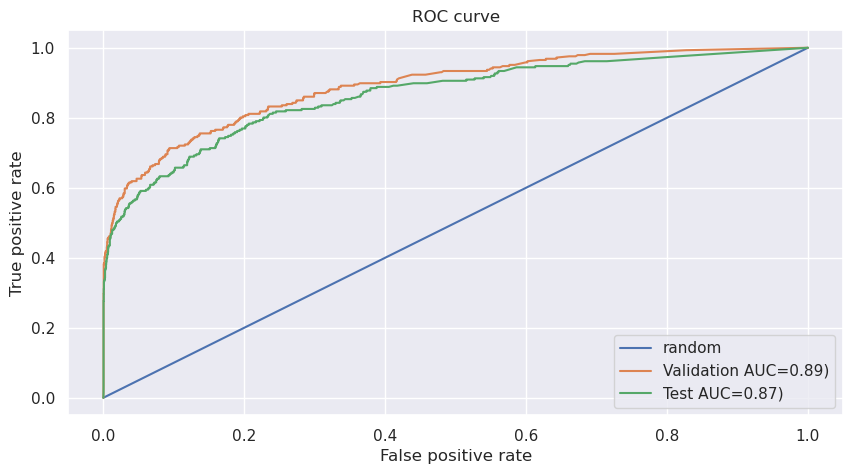

In [26]:
fig = plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], label='random')

plt.plot(fpr_validation, tpr_validation, label= 'Validation AUC=' + str(np.round(auc_validation, 2)) + ')')
plt.plot(fpr_test, tpr_test, label= 'Test AUC=' + str(np.round(auc_test, 2)) + ')')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

plt.show()

If the user would also like to assign a 1, 0 classification to each customer we can use the result from the ROC curve. Based on the validation ROC curve result we select the optimum threshold value based on Youden's Index. Any probabilities greater than the selected threshold will be classed as 1, otherwise 0. 

In [27]:
# get the optimal threshold based on Youden's index
idx_opt_thres = np.argmax(tpr_validation - fpr_validation)
opt_threshold = thresholds_validation[idx_opt_thres]
print(opt_threshold)
y_pred_class_validation = y_pred_validation >= opt_threshold
y_pred_class_validation = y_pred_class_validation.astype(int)
y_pred_class_test = y_pred_test >= opt_threshold
y_pred_class_test = y_pred_class_test.astype(int)

0.07717640910868107


We'll next look at the confusion matrices for the validation and test results at the threshold selected above. At this threshold the classifier does a good job at correctly predicting those who readmit or not. However, it also misclassifies quite a few patients as readmitting to a hospital when they have not actually readmitted (False Positives). Depending on the business decision to be made from the model, this result may not be sufficient. Based on this, the analyst may want to change the threshold by reducing the false positive rate (as commented out above). Doing this does result in a trade off and the number of true positives (predicted to miss the payment and actually missed it) would reduce. 

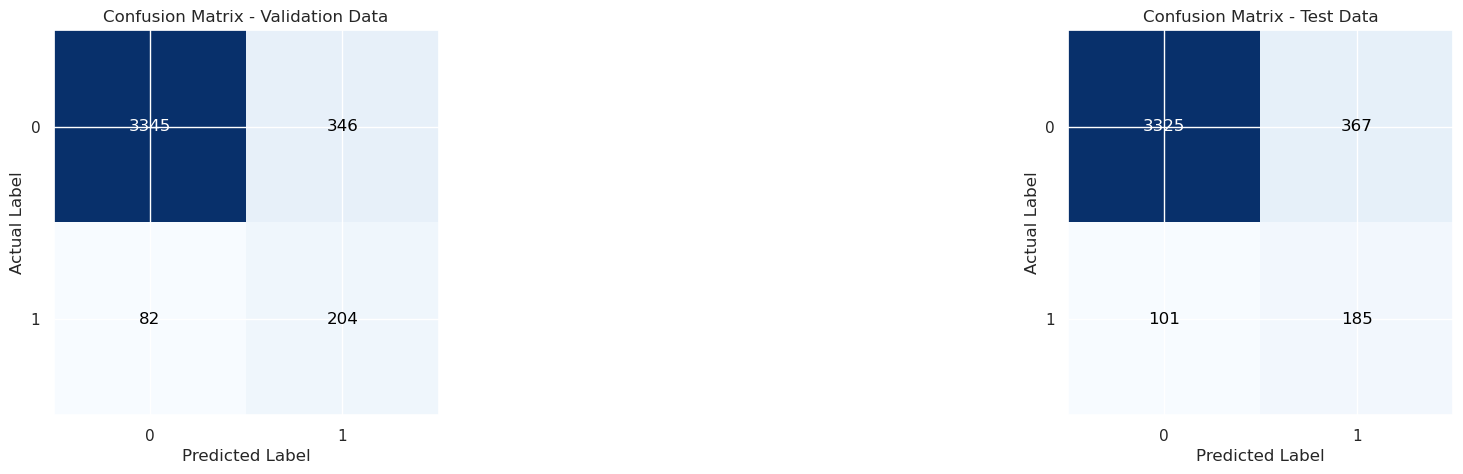

In [28]:
confusion_matrix_validation = metrics.confusion_matrix(y_validation, y_pred_class_validation, labels=[0,1])
confusion_matrix_test = metrics.confusion_matrix(y_test, y_pred_class_test, labels=[0,1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 5))

ax1.imshow(confusion_matrix_validation, interpolation='nearest', cmap=plt.cm.Blues)
ax1.set_title('Confusion Matrix - Validation Data')
tick_marks = np.arange(2)
ax1.set_xticks(tick_marks)
ax1.set_yticks(tick_marks)
ax1.set_ylabel('Actual Label')
ax1.set_xlabel('Predicted Label')
# iterate through the confusion matrix array with indexing, use this to plot counts on the chart
cm_iterator = np.nditer(confusion_matrix_validation, flags=['multi_index'])
while not cm_iterator.finished:
    num_occurances = cm_iterator[0]
    y = cm_iterator.multi_index[0]
    x = cm_iterator.multi_index[1]
    ax1.text(x, y, num_occurances, color="white" if confusion_matrix_validation[x, y] > confusion_matrix_validation.max()/2 else "black", ha='center', va='center')
    cm_iterator.iternext()

ax2.imshow(confusion_matrix_test, interpolation='nearest', cmap=plt.cm.Blues)
ax2.set_title('Confusion Matrix - Test Data')
ax2.set_xticks(tick_marks)
ax2.set_yticks(tick_marks)
ax2.set_ylabel('Actual Label')
ax2.set_xlabel('Predicted Label')
# iterate through the confusion matrix array with indexing, use this to plot counts on the chart
cm_iterator = np.nditer(confusion_matrix_test, flags=['multi_index'])
while not cm_iterator.finished:
    num_occurances = cm_iterator[0]
    y = cm_iterator.multi_index[0]
    x = cm_iterator.multi_index[1]
    ax2.text(x, y, num_occurances, color="white" if confusion_matrix_test[x, y] > confusion_matrix_test.max()/2 else "black", ha='center', va='center')
    cm_iterator.iternext()

## Feature Importance of the model
With tree based models we can view variable importance plots. These plots indicate, at the feature level, some importance for the variable in classifying the outcome variable. It uses gini importance (mean decrease in impurity) which looks at node impurity. Node impurity is just looking at how well a tree splits the data. Technically it calculates each feature importance as the sum over the number of splits that include the feature, proportionally to the number of samples it splits.

We'll take a look at the feature importance plots for the random forest models. 

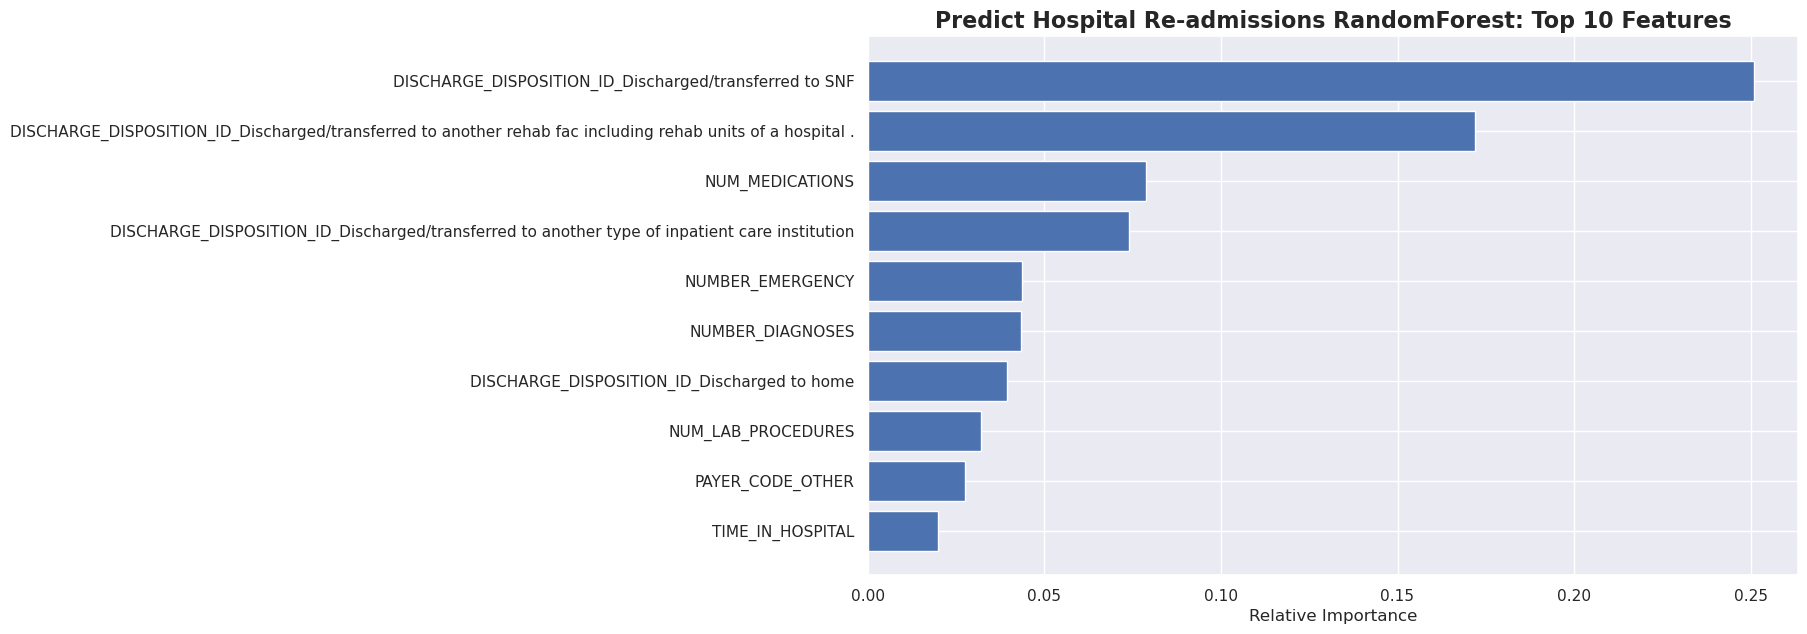

In [29]:
plot_feature_importance(feature_list=numeric_features_list, 
                        feature_importances=model_pipeline.named_steps['model'].feature_importances_, 
                        title="Predict Hospital Re-admissions RandomForest: Top 10 Features")

### Save Data for RShiny Dashboard

We save the data out for use in the RShiny dashboard. We score the `df_hospital` dataframe and save the dataframe and scores out. This data contains records for all patients and their prediction for hospital readmissions.

In [30]:
df_save=df_hospital[numerical_cols+[target_col]+categorical_cols].copy()

X_total_postprocess = fitted_preprocessor.transform(df_save.drop([target_col], axis=1))

y_pred_total =model_pipeline.named_steps['model'].predict_proba(X_total_postprocess)[:,1]

y_pred_class_total = y_pred_total >= opt_threshold
y_pred_class_total = y_pred_class_total.astype(int)

df_hospital['predicted_probability'] = y_pred_total
df_hospital['predicted_class'] = y_pred_class_total


project.save_data('model-output-summary.csv', df_hospital.to_csv(index=False), overwrite=True)

{'file_name': 'model-output-summary.csv',
 'message': 'File saved to project storage.',
 'asset_id': 'b1374b31-934f-4958-99bc-45a586929f6c'}

### Explanation for individual patient outcomes
We use `lime` based explainer to explain the readmission prediction for any patient. Below cell shows an explanation of all the features impacting the readmission risk for a patient with specified patient number.

In [31]:
# Select a patient for explanation 
patient_number=87652710
df_explain=df_hospital[df_hospital.PATIENT_NBR==patient_number][numerical_cols+categorical_cols].copy()
# transform patients data using fitted preprocessor
explain_postprocess=fitted_preprocessor.transform(df_explain)

# use LimeTabularExplainer to train explainer 
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_postprocess,feature_names = numeric_features_list,class_names=['Not-Readmitted','Re-admitted'],kernel_width=5,mode="classification")
def model_prediction(data_asarray):
    data_asframe =  pd.DataFrame(data_asarray.tolist(),columns=numeric_features_list)
    return model_pipeline.named_steps['model'].predict_proba(data_asframe.to_numpy())

# Pass single patient record to get explanation
exp = explainer.explain_instance(
    data_row=explain_postprocess.toarray()[0], 
    predict_fn=model_prediction
)

exp.show_in_notebook(show_table=True)



Above chart shows the variables in the right push the outcome towards `Readmitted` whereas the variable in the left push the outcome towards `Not-Readmitted`. It can also be plotted as below.

Text(0.5, 1.0, 'Effect on Prediction')

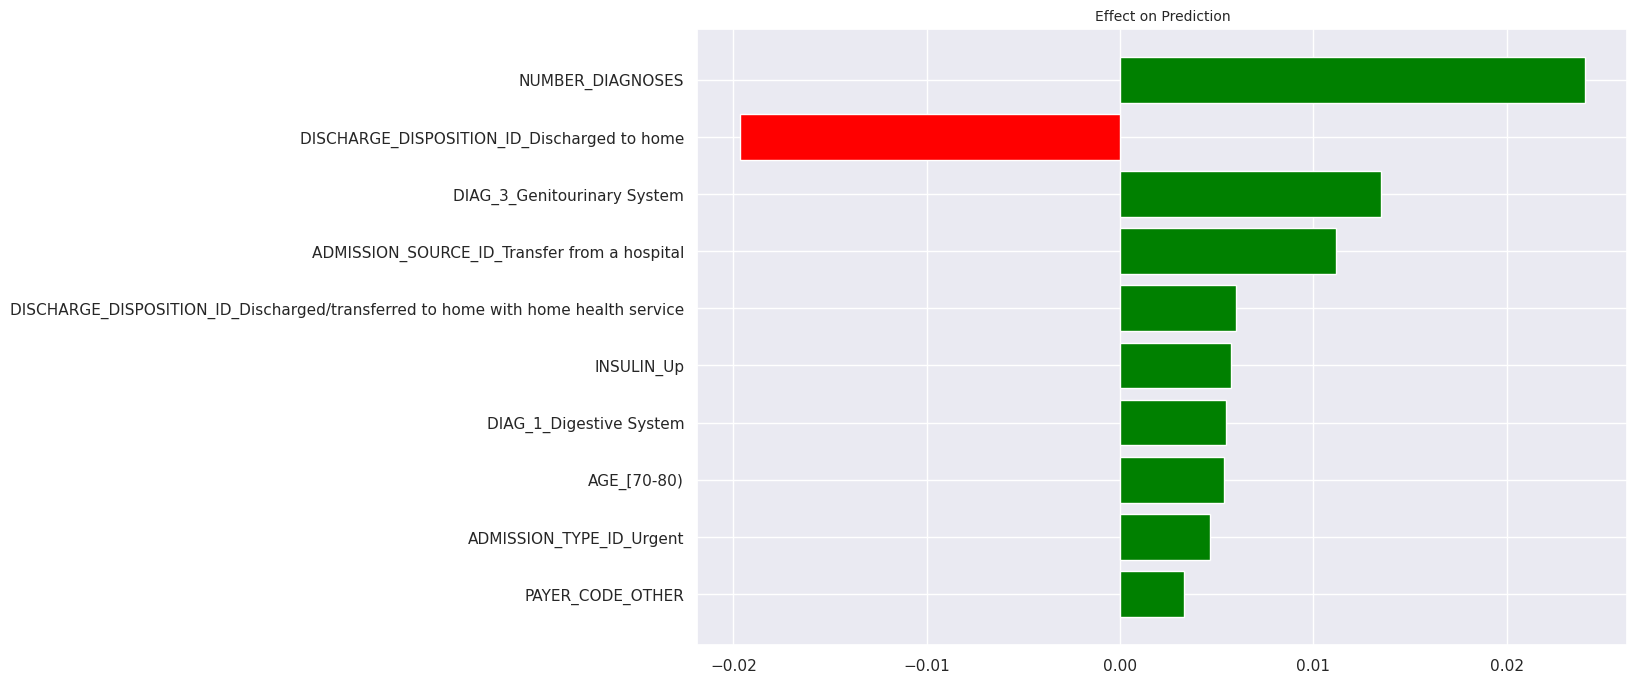

In [32]:
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
# Plot the prediction explaination
figsize(12, 8)
plt.rcParams['font.size'] = 20
exp.as_pyplot_figure()
plt.title('Effect on Prediction', size = 10)


A similar explanation can be represented for all patients. We randomly select 100 patients to show the explanation on the r-shiny dashboard. If we want to extend to more patients then specify the number in the cell below. Based on the number of patients selected, the below cell may take longer to run.

In [33]:
num_pat_explain=20
explain_list=[]
for i in range(num_pat_explain):
    exp = explainer.explain_instance(
        data_row=X_total_postprocess[i].toarray()[0], 
        predict_fn=model_prediction
    )
    explain_list.append(exp.as_list())
    
    

In [34]:
limeresults=df_hospital.head(20).copy()
limeresults['LIME_Features']=explain_list

project.save_data('explanation-results.csv', limeresults.to_csv(index=False), overwrite=True)

{'file_name': 'explanation-results.csv',
 'message': 'File saved to project storage.',
 'asset_id': '8391ee4e-2b9d-4f60-a465-e0afbdeab5b0'}

## Save the Pipeline to Cloud Pak for Data

In the next steps we save and deploy the pipeline. The pipeline can be saved and deployed in the same way we save and deploy models. 

Before we save the pipeline we must create a deployment space. Watson Machine Learning provides deployment spaces where the user can save, configure and deploy their models. We can save models, functions and data assets in this space. 

The steps involved in saving and deploying the pipeline are detailed in the following cells. We will use the [ibm-watson-machine-learning](http://ibm-wml-api-pyclient.mybluemix.net) package to complete these stepss. 

### User Inputs

The user can specify the name for the space, models and model deployments.  <br> Model and its deployment will be stored in the deployment space. The deployment space can be created programmatically using `ibm-watson-machine-learning` client. <br>
If a space with specified space_name already exists, user can either use the existing space by specifying `use_existing_space=True` or delete the existing space and create a new one by specifying `use_existing_space=False` below. By default `use_existing_space` is set to `True`.

In [35]:
# Specify a name for the space being created, the saved model and the model deployment
space_name = 'Hospital Readmission Prediction Space'
model_name = 'Hospital Readmission Prediction Model'
deployment_name = 'Hospital Readmission Prediction Deployment'

use_existing_space=True

In [43]:
from ibm_watson_machine_learning import APIClient
import os

token = os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
   "token": token,
   "instance_id" : "openshift",
   "url": os.environ['RUNTIME_ENV_APSX_URL'],
   "version": "4.6"
}

client = APIClient(wml_credentials)

### Create the Deployment Space

Create a new deployment space using name of the space as specified in the user inputs cell above. The space name will be used in future to identify this space. 

By default, if the space with specified name already exists, the existing space will be used to store and deploy the models.

In [44]:
space_uid=""
for space in client.spaces.get_details()['resources']:

    if space['entity']['name'] ==space_name:
        print("Deployment space with ",space_name,"already exists . .")
        space_uid=space['metadata']['id']
        client.set.default_space(space_uid)
        if(use_existing_space==False):

            for deployment in client.deployments.get_details()['resources']:
                print("Deleting deployment",deployment['entity']['name'], "in the space",)
                deployment_id=deployment['metadata']['id']
                client.deployments.delete(deployment_id)
            print("Deleting Space ",space_name,)
            client.spaces.delete(space_uid)
            time.sleep(5)
        else:
            print("Using the existing space")
            
            
if (space_uid=="" or use_existing_space==False):
    print("\nCreating a new deployment space -",space_name)
    # create the space and set it as default
    space_meta_data = {
        client.spaces.ConfigurationMetaNames.NAME : space_name

        }

    stored_space_details = client.spaces.store(space_meta_data)

    space_uid = stored_space_details['metadata']['id']

    client.set.default_space(space_uid)

Deployment space with  Hospital Readmission Prediction Space already exists . .
Using the existing space


### Store the Pipeline Details
Store the pipeline in the deployment space. Again, the name for the pipeline is specified in the user inputs cell above.  Software specification and default tag for the model are specified in the model metadata. <br>
The Software Specification refers to the runtime used in the Notebook, WML training and WML deployment. We use the software specification `runtime-22.2-py3.10` to store the models. We get the ID of the software specification and include it in the metadata when storing the model.  Available Software specifications can be retrieved using `client.software_specifications.list()`. 

In [45]:
fields=X_train.columns.tolist()
metadata_dict = {'target_col' : target_col, 'probability_threshold' : opt_threshold, 'numeric_features_list':numeric_features_list,'fields':fields,'categorical_cols':categorical_cols}

In [50]:
sw_spec_uid = client.software_specifications.get_uid_by_name("runtime-22.2-py3.10")

metadata = {
    client.repository.ModelMetaNames.NAME: model_name,
    client.repository.ModelMetaNames.TYPE: "scikit-learn_1.1",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sw_spec_uid ,
    client.repository.ModelMetaNames.INPUT_DATA_SCHEMA:[{'id': '1', 'type': 'struct', 'fields': [{"name":column_name,"type":str(column_type[0])} for column_name,column_type in pd.DataFrame(X_train.dtypes).T.to_dict('list').items()]}],
    client.repository.ModelMetaNames.TAGS: ['hospital_readmission_pipeline_tag'],
    
}

stored_model_details = client.repository.store_model(model=model_pipeline, meta_props=metadata)
stored_model_details




{'entity': {'hybrid_pipeline_software_specs': [],
  'schemas': {'input': [{'fields': [{'name': 'TIME_IN_HOSPITAL',
       'type': 'int64'},
      {'name': 'NUM_LAB_PROCEDURES', 'type': 'int64'},
      {'name': 'NUM_PROCEDURES', 'type': 'int64'},
      {'name': 'NUM_MEDICATIONS', 'type': 'int64'},
      {'name': 'NUMBER_OUTPATIENT', 'type': 'int64'},
      {'name': 'NUMBER_EMERGENCY', 'type': 'int64'},
      {'name': 'NUMBER_DIAGNOSES', 'type': 'int64'},
      {'name': 'RACE', 'type': 'object'},
      {'name': 'GENDER', 'type': 'object'},
      {'name': 'AGE', 'type': 'object'},
      {'name': 'WEIGHT', 'type': 'object'},
      {'name': 'ADMISSION_TYPE_ID', 'type': 'object'},
      {'name': 'DISCHARGE_DISPOSITION_ID', 'type': 'object'},
      {'name': 'ADMISSION_SOURCE_ID', 'type': 'object'},
      {'name': 'PAYER_CODE', 'type': 'object'},
      {'name': 'DIAG_1', 'type': 'object'},
      {'name': 'DIAG_2', 'type': 'object'},
      {'name': 'DIAG_3', 'type': 'object'},
      {'name': 'M

### Deploy the Model Pipeline

Deploy the saved model. The deployment name is specified in the user inputs cell above. Again, a default tag for the deployment is specified in the deployment metadata. 


In [51]:
# deploy the model pipeline
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: deployment_name,
    client.deployments.ConfigurationMetaNames.TAGS : [ 'hospital_readmission_pipeline_deployment_tag'],
    client.deployments.ConfigurationMetaNames.SERVING_NAME: model_name.lower().replace(' ','')[:30]+''.join(random.choice(string.ascii_lowercase + string.digits) for _ in range(6)),
    client.deployments.ConfigurationMetaNames.CUSTOM: metadata_dict
}

# deploy the model

model_uid = stored_model_details["metadata"]["id"]
deployment_details = client.deployments.create(artifact_uid=model_uid, meta_props=meta_props)





#######################################################################################

Synchronous deployment creation for uid: '5babab44-7ff0-44f6-9f72-495ef7f6ee61' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='4d854e80-744e-4e9e-bed7-9b08d2fa8784'
------------------------------------------------------------------------------------------------




### Sample Scoring 
The above model deployment can be tested by sending sample payload as input data. The below cell tests the model by predicting re-admission for one specific patient id.

In [52]:

# Select sample customer ids to score
pat_IDS=[89869032]

#Get the deployment id for the deployed model
deployment_uid=client.deployments.get_uid(deployment_details)

# Filter these customers records from df_raw
df_score=df_hospital[df_hospital['PATIENT_NBR'].isin(pat_IDS)]
values=df_score[fields].values.tolist()

In [53]:


payload_scoring={"input_data": [{"fields": fields,"values": values}]}


# Pass the payload to wml client to predict attrition_status for the sample records
scoring_response = client.deployments.score(deployment_uid, payload_scoring)
scoring_response

{'predictions': [{'fields': ['prediction', 'probability'],
   'values': [[0, [0.933690686432146, 0.06630931356785419]]]}]}

**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2021,2022. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>**